In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
import radialProfile
from matplotlib.colors import LogNorm
from tqdm import tqdm_notebook, tnrange, tqdm
from powernoise import powernoise # Stolen from https://gist.github.com/j-faria/7961488
from astropy.modeling import models, fitting

First, let's generate a mock image. Here I'll use Power-law correlated noise. You could use Gaussian noise like
```python
#Generate mock-data - Gaussian!
xsize = 100
ysize = 100
image = np.random.normal(size=[ysize, xsize])
```

In [2]:
# Generate mock-data - Power spectrum!
xsize = 100
ysize = 100
a = -5/3
kolmo = powernoise(5/3, ysize*xsize, normalize=True)
image = np.reshape(kolmo, [ysize, xsize])

Let's have a look at the image

Text(0, 0.5, 'y')

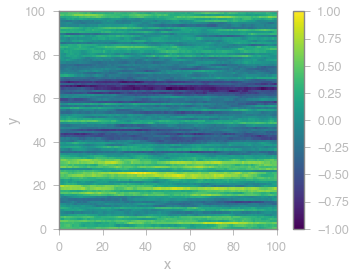

In [3]:
plt.figure()
plt.pcolormesh(image)
plt.colorbar()
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel('x')
plt.ylabel('y')

Now we'll take the Fourier transform of the image using `scipy`. We can also get the spatial frequencies from `fftfreq`

We'll also shift the image and frequencies with `fftshift` such that the frequency of '0' is at the centre of the image.

From the complex Fourier transformed image, we'll compute the power and the phase.

To get the power spectrum, we'll take an average in azimuth from the centre of the image. We'll get the same information for the spatial frequencies.

In [4]:
# Take the fourier transform of the image.
imag_fft = fftpack.fft2(image)
 
# Now shift the quadrants around so that low spatial frequencies are in
# the center of the 2D fourier transformed image.
imag_fft_s = fftpack.fftshift( imag_fft )

# Calcudate the spatial frequencies
x_freq = fftpack.fftshift(fftpack.fftfreq(xsize, d=1))
y_freq = fftpack.fftshift(fftpack.fftfreq(ysize, d=1))

X_freq, Y_freq = np.meshgrid(x_freq, y_freq)
R_freq = np.sqrt(X_freq**2 + Y_freq**2)
freq_1d = radialProfile.azimuthalAverage(R_freq)
 
# Calculate a 2D power spectrum
power_2d = np.abs( imag_fft_s )**2
phase_2d = np.angle( imag_fft_s )
 
# Calculate the azimuthally averaged 1D power spectrum
power_1d = radialProfile.azimuthalAverage(power_2d)

Text(0.5, 1.0, '2D phase')

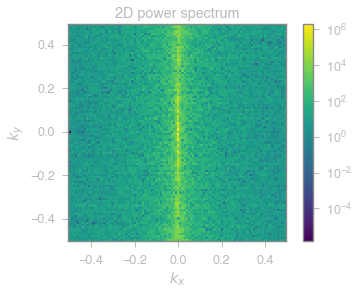

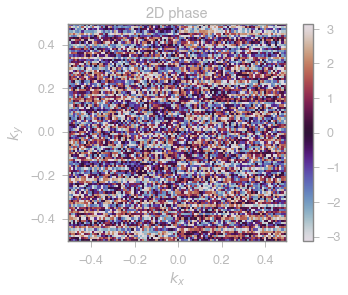

In [5]:
plt.figure()
plt.pcolormesh(x_freq, y_freq, power_2d, norm=LogNorm())
plt.colorbar()
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel("$k_x$")
plt.ylabel("$k_y$")
plt.title("2D power spectrum")

plt.figure()
plt.pcolormesh(x_freq, y_freq, phase_2d, cmap=plt.cm.twilight)
plt.colorbar()
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel("$k_x$")
plt.ylabel("$k_y$")
plt.title("2D phase")

Text(0.5, 1.0, '1D power spectrum')

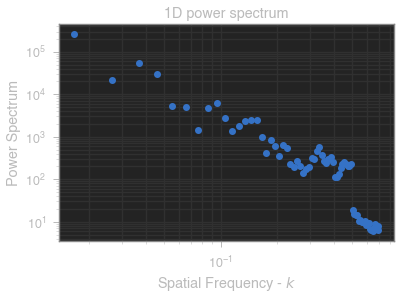

In [6]:
plt.figure()
plt.plot(freq_1d, power_1d,'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Spatial Frequency - $k$')
plt.ylabel('Power Spectrum')
plt.grid(which='both')
plt.title("1D power spectrum")

Now we'll fold in uncertainty in each pixel of the image. We'll assumue Gaussian distribution on the error, with the same level of error across the image.

For each pixel we'll sample a Gaussian distribution, taking the mean to be the value from the image, and the standard deviation from the error map with 1000 samples.

In doing so we'll create a 3D arrays, `image_dist`, containing the sampling of values for each pixel.

In [7]:
# Now lets sample a Gaussian distribution for each pixel
samples = 1000
error_val = 1
# I'll just use 1.0 as the standard deviation
error  = np.ones_like(image) * error_val
samples = 1000
image_dist = np.zeros([samples,ysize,xsize])

# I'm currently using nested for loops...which is bad...
## There should be a way to do this in NumPy, but I'm feeling lazy
for i in tnrange(ysize):
    for j in range(xsize):
        image_dist[:,i,j] = np.random.normal(loc=image[i,j], scale=error[i,j], size=samples)

/var/folders/rg/tk14ndkj435d8d1yj25dbz1w00p7kq/T/ipykernel_67299/4182734636.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(ysize):


  0%|          | 0/100 [00:00<?, ?it/s]

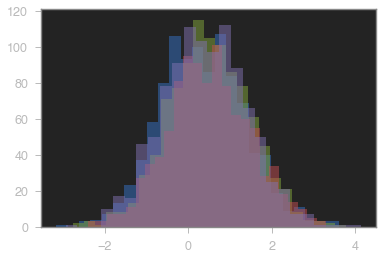

In [8]:
# Lets look at the histogram of the first pixel
plt.figure()
for dist in image_dist[:,0,::25].T:
    plt.hist(dist.ravel(), bins=25, alpha=0.5, histtype='stepfilled')

Now, just like above, we'll take the Fourier transform of the distribution array.

In [9]:
# Take the fourier transform of the image.
dist_fft = fftpack.fft2(image_dist)

# Now shift the quadrants around so that low spatial frequencies are in
# the center of the 2D fourier transformed image.
dist_fft_s = fftpack.fftshift(dist_fft)
# Calculate a 2D power spectrum
power_2d_dist = np.abs(dist_fft_s)**2

We can now iterate through each sample and compute the 1D power spectrum

In [10]:
# Calculate the azimuthally averaged 1D power spectrum
## Currently doing this as a loop, but could be fixed in 'radialProfile.py' to use NumPy. This 
## would be much faster!
power_1d_dist = []
for sample in tqdm_notebook(power_2d_dist):
    power_1d_dist.append(radialProfile.azimuthalAverage(sample))
power_1d_dist = np.array(power_1d_dist)

/var/folders/rg/tk14ndkj435d8d1yj25dbz1w00p7kq/T/ipykernel_67299/3723478196.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm_notebook(power_2d_dist):


  0%|          | 0/1000 [00:00<?, ?it/s]

Now we have MANY samples! Lets see how they all look!

Text(0.5, 1.0, '1D power spectrum')

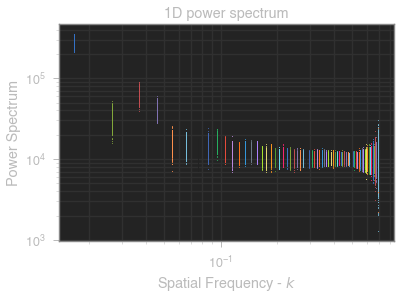

In [11]:

plt.figure()
for i, d in enumerate(power_1d_dist.T):
    plt.plot([freq_1d[i]] * len(d),d, 'o', markersize=1, alpha=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Spatial Frequency - $k$')
plt.ylabel('Power Spectrum')
plt.grid(which='both')
plt.title("1D power spectrum")

Now lets use the median and percentiles of these spectra. This gives as an estiamate of the uncertainty in the power spectrum.


In [12]:
power_1d_16, power_1d_med, power_1d_84 = np.nanpercentile(power_1d_dist, (16,50,84), axis=0)
power_1d_err_plus = power_1d_84 - power_1d_med
power_1d_err_minus = power_1d_med - power_1d_16

Lets plot it! First using error bars


Text(0.5, 1.0, '1D power spectrum')

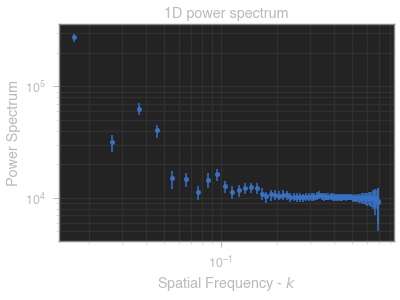

In [13]:
plt.figure()
plt.errorbar(freq_1d, power_1d_med, 
            yerr=[power_1d_err_plus, power_1d_err_minus],
             fmt='o', ms=5, alpha=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Spatial Frequency - $k$')
plt.ylabel('Power Spectrum')
plt.grid(which='both')
plt.title("1D power spectrum")

Text(0.5, 1.0, '1D power spectrum')

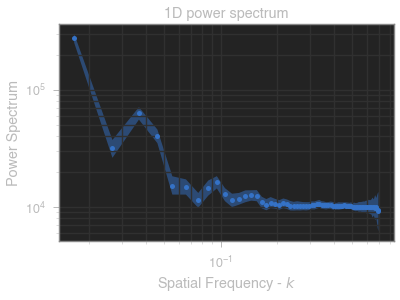

In [14]:
# Lets try with fill_between
plt.figure()
plt.plot(freq_1d, power_1d_med, 'o', markersize=5)
plt.fill_between(freq_1d, power_1d_16, power_1d_84, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Spatial Frequency - $k$')
plt.ylabel('Power Spectrum')
plt.grid(which='both')
plt.title("1D power spectrum")

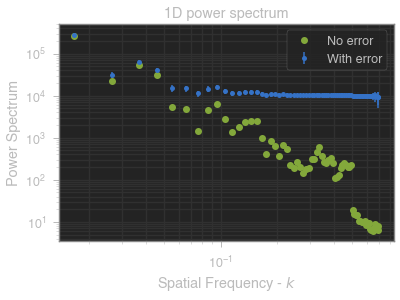

In [15]:
plt.figure()
plt.errorbar(freq_1d, power_1d_med, 
            yerr=[power_1d_err_plus, power_1d_err_minus],
             fmt='o', ms=5, alpha=1, label="With error")
plt.plot(freq_1d, power_1d,'o', label="No error")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Spatial Frequency - $k$')
plt.ylabel('Power Spectrum')
plt.grid(which='both')
plt.title("1D power spectrum")
plt.legend()